<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/geometrie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import torch


def extractCropOld(ABCD, img, s=256, inner=2048):
    EPS, img = 0.1, img
    _, H, W = img.shape
    rA, cA, rB, cB, rC, cC, rD, cD = ABCD

    tmp = (torch.arange(inner).float() + 0.5) / inner
    u = tmp.view(-1, 1).expand(inner, inner)
    v = tmp.view(1, -1).expand(inner, inner)
    mask = (u + v <= 1.001).float()
    maskbis = (u + v <= 1.001).float()

    rP = (rB - rA) * u + (rD - rA) * v + rA
    rPc = torch.clamp(rP, EPS, H - EPS)
    cP = (cB - cA) * u + (cD - cA) * v + cA
    cPc = torch.clamp(cP, EPS, W - EPS)
    rP, cP = rPc.long().flatten(), cPc.long().flatten()
    out1 = img[:, rP, cP].view(3, inner, inner) * mask.view(1, inner, inner)

    rP = (rD - rC) * u + (rB - rC) * v + rC
    rPc = torch.clamp(rP, EPS, H - EPS)
    cP = (cD - cC) * u + (cB - cC) * v + cC
    cPc = torch.clamp(cP, EPS, W - EPS)
    rP, cP = rPc.long().flatten(), cPc.long().flatten()
    out2 = img[:, rP, cP].view(3, inner, inner) * mask.view(1, inner, inner)
    out2 = torch.flip(out2, dims=[1, 2])
    maskbis = torch.flip(maskbis, dims=[0, 1])

    mask = (mask + maskbis + EPS).view(1, 1, inner, inner)
    out = (out1 + out2).view(1, 3, inner, inner) / mask
    out = torch.nn.functional.interpolate(out, size=(s, s), mode="bilinear")
    return out[0]

def estimation(U, V):
    A = []
    for (x, y), (X, Y) in zip(U, V):
        A.append([x, y, 1, 0, 0, 0, -X*x, -X*y, -X])
        A.append([0, 0, 0, x, y, 1, -Y*x, -Y*y, -Y])
    A = torch.Tensor(A)

    _, _, Vh = torch.linalg.svd(A)
    H = Vh[-1, :].reshape(3, 3)  # Last row of V (smallest singular value)
    return H / H[2, 2]  # Normalize so that H[2,2] = 1


def extractCrop(ABCD, img, s=256, inner=1024):
    rA, cA, rB, cB, rC, cC, rD, cD = ABCD

    P = torch.Tensor([[0., 0.], [1., 0.], [1., 1.], [0., 1.]])
    Q = torch.Tensor([[rA,cA],[rB,cB],[rC,cC],[rD,cD]])
    M = estimation(P,Q)

    tmp = torch.arange(inner).float()/inner
    u = tmp.view(-1, 1).expand(inner, inner)
    v = tmp.view(1, -1).expand(inner, inner)
    uv = torch.stack([u,v,torch.ones(inner,inner)],dim=0)

    uv = torch.matmul(M,uv.flatten(1))
    u,v = uv[0]/(uv[2]+0.00001),uv[1]/(uv[2]+0.00001)
    _,H,W = img.shape
    u,v = torch.clamp(u,0,H-0.5),torch.clamp(v,0,W-0.5)
    out = img[:, u.long(), v.long()].view(1,3,inner,inner)

    out = torch.nn.functional.interpolate(out, size=(s, s), mode="bilinear")
    return out[0]

In [118]:
def baddrawsegment(img,AB, inner = 2048):
    rA, cA, rB, cB = AB
    for i in range(2048):
        r = rA*(1.-i/2048)+i/2048*rB
        c = cA*(1.-i/2048)+i/2048*cB
        img[:,int(r),int(c)]=0

def baddrawrect(img,ABCD):
    rA, cA, rB, cB, rC, cC, rD, cD = ABCD
    baddrawsegment(img,(rA, cA, rB, cB))
    baddrawsegment(img,(rC, cC, rD, cD))
    baddrawsegment(img,(rA, cA, rD, cD))
    baddrawsegment(img,(rB, cB, rC, cC))

In [119]:
import torchvision
import os

if not os.path.exists("build/5495485981_3293917c4c_z.jpg"):
    os.system("wget http://farm6.staticflickr.com/5300/5495485981_3293917c4c_z.jpg")
img = torchvision.io.read_image("5495485981_3293917c4c_z.jpg") / 255.0

_, H, W = img.shape
ABCD = [30.0, 30.0, H - 70.0, 30.0, H - 180.0, W * 2 // 3+50, 140.0, W * 2 // 3+50]
crop = extractCrop(ABCD,img)
oldcrop = extractCropOld(ABCD,img)
baddrawrect(img,ABCD)
cropbis = extractCrop(ABCD,img)
oldcropbis = extractCropOld(ABCD,img)

In [120]:
import matplotlib.pyplot as plt
def visuimage(img):
    visu = torch.stack([img[0],img[1],img[2]],dim=-1)
    plt.imshow(visu)
    plt.axis('off')
    plt.show()

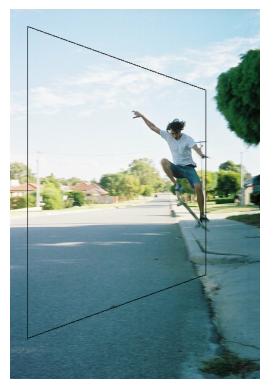

In [121]:
visuimage(img)


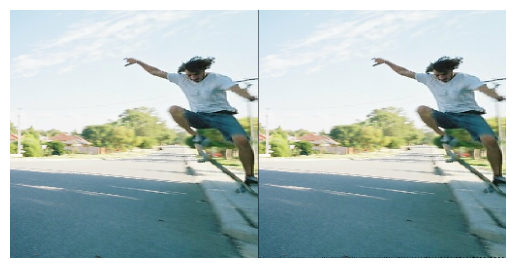

In [122]:
visuimage(torch.cat([crop,cropbis],dim=-1))

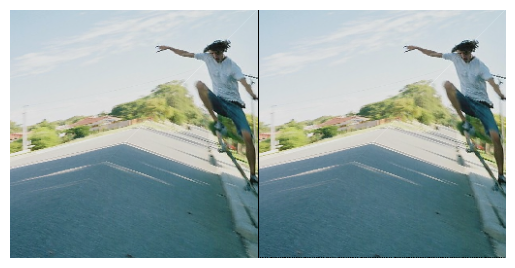

In [123]:
visuimage(torch.cat([oldcrop,oldcropbis],dim=-1))